# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Basic RNNs

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time-offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


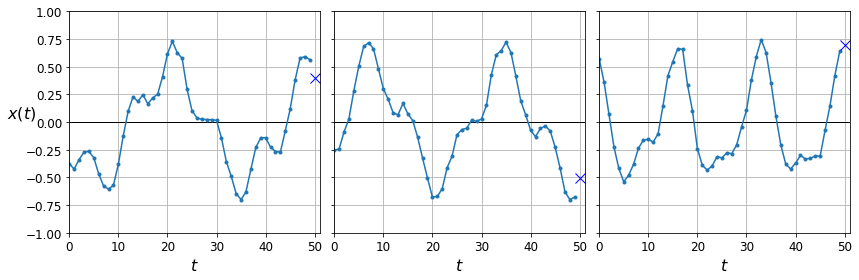

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [6]:
y_pred = X_valid[:, -1] 
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

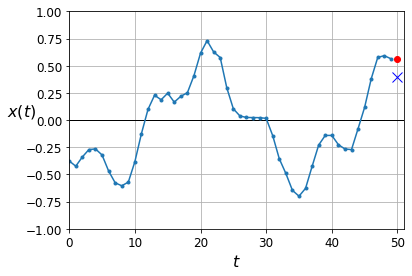

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 103us/sample - loss: 0.1008 - val_loss: 0.0552
Epoch 2/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0388 - val_loss: 0.0270
Epoch 3/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0206 - val_loss: 0.0160
Epoch 4/20
7000/7000 [==============================] - 0s 29us/sample - loss: 0.0132 - val_loss: 0.0115
Epoch 5/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0103 - val_loss: 0.0097
Epoch 6/20
7000/7000 [==============================] - 0s 29us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 0s 27us/sample - loss: 0.0079 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0072 - val_loss: 0.0073
Epoch 9/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 

In [9]:
model.evaluate(X_valid, y_valid, verbose=0)

0.004112337168306112

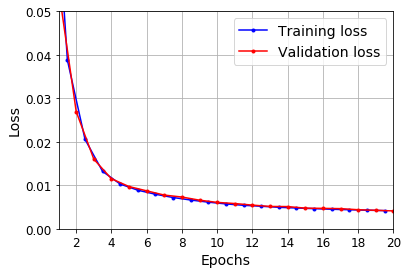

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

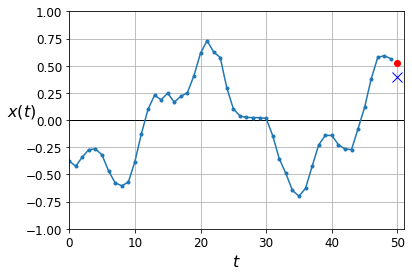

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 395us/sample - loss: 0.0979 - val_loss: 0.0490
Epoch 2/20
7000/7000 [==============================] - 2s 266us/sample - loss: 0.0371 - val_loss: 0.0297
Epoch 3/20
7000/7000 [==============================] - 2s 286us/sample - loss: 0.0254 - val_loss: 0.0219
Epoch 4/20
7000/7000 [==============================] - 2s 284us/sample - loss: 0.0199 - val_loss: 0.0177
Epoch 5/20
7000/7000 [==============================] - 2s 260us/sample - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
7000/7000 [==============================] - 2s 266us/sample - loss: 0.0146 - val_loss: 0.0135
Epoch 7/20
7000/7000 [==============================] - 2s 273us/sample - loss: 0.0133 - val_loss: 0.0124
Epoch 8/20
7000/7000 [==============================] - 2s 307us/sample - loss: 0.0124 - val_loss: 0.0117
Epoch 9/20
7000/7000 [==============================] - 3s 359us/sample - loss: 0.0119 - val_loss: 0.011

In [13]:
model.evaluate(X_valid, y_valid, verbose=0)

0.010903828606009483

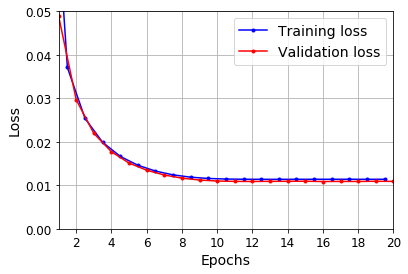

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

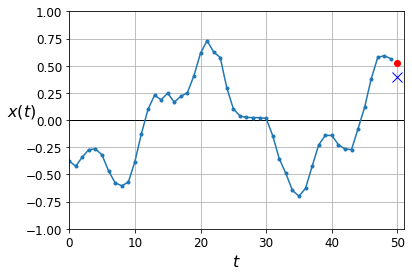

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure15_7.png?raw=true" alt="Figure 15-7" width=600>

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1) # presumably, not do much work for the job
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0531 - val_loss: 0.0083
Epoch 2/20
7000/7000 [==============================] - 7s 935us/sample - loss: 0.0074 - val_loss: 0.0055
Epoch 3/20
7000/7000 [==============================] - 7s 983us/sample - loss: 0.0054 - val_loss: 0.0050
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0047 - val_loss: 0.0041
Epoch 5/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0044 - val_loss: 0.0041
Epoch 6/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0041 - val_loss: 0.0040
Epoch 7/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0038 - val_loss: 0.0035
Epoch 8/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0038 - val_loss: 0.0039
Epoch 9/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 10/

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/return_sequences.jpg?raw=true" alt="keras return_sequences reference" width=700>

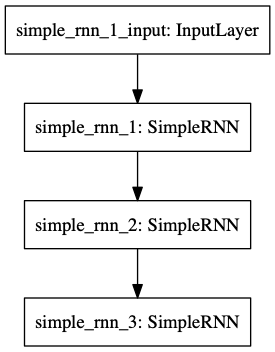

In [17]:
# plot model structure
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.evaluate(X_valid, y_valid, verbose=0)

0.003111328933387995

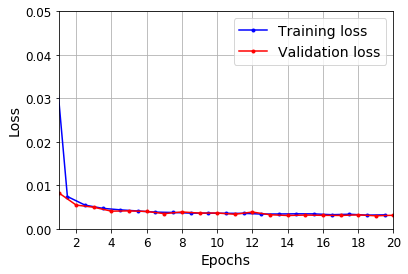

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

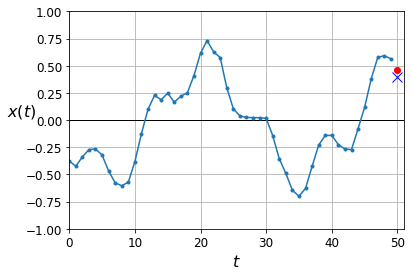

In [21]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1) # changed to Dense layer
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0240 - val_loss: 0.0050
Epoch 2/20
7000/7000 [==============================] - 6s 791us/sample - loss: 0.0043 - val_loss: 0.0035
Epoch 3/20
7000/7000 [==============================] - 5s 768us/sample - loss: 0.0036 - val_loss: 0.0033
Epoch 4/20
7000/7000 [==============================] - 5s 748us/sample - loss: 0.0034 - val_loss: 0.0032
Epoch 5/20
7000/7000 [==============================] - 5s 709us/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 5s 714us/sample - loss: 0.0032 - val_loss: 0.0034
Epoch 7/20
7000/7000 [==============================] - 5s 728us/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 5s 715us/sample - loss: 0.0030 - val_loss: 0.0031
Epoch 9/20
7000/7000 [==============================] - 5s 718us/sample - loss: 0.0030 - val_loss: 0.0031


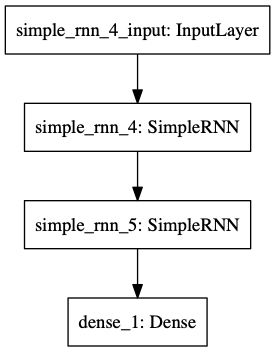

In [23]:
# plot model structure
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.evaluate(X_valid, y_valid, verbose=0)

0.0028335074987262485

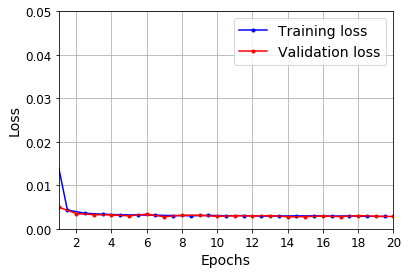

In [26]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

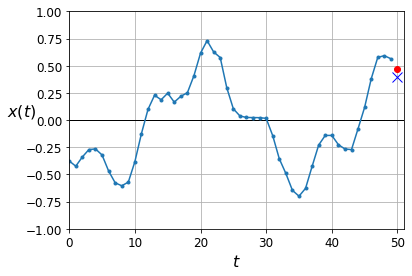

In [27]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

### option 1: one at a time using pretrained model

In [28]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :] ## (1, 1) -> (1, 1(new), 1)
    X = np.concatenate([X, y_pred_one], axis=1) ## X: (1, n_steps, 1) -> (1, n_steps+1, 1)

Y_pred = X[:, n_steps:] 

In [29]:
Y_pred.shape

(1, 10, 1)

In [30]:
Y_pred

array([[[ 0.6438659 ],
        [ 0.72457373],
        [ 0.73793393],
        [ 0.6387154 ],
        [ 0.44228697],
        [ 0.18214636],
        [-0.05097207],
        [-0.239856  ],
        [-0.3496014 ],
        [-0.3637287 ]]], dtype=float32)

Saving figure forecast_ahead_plot


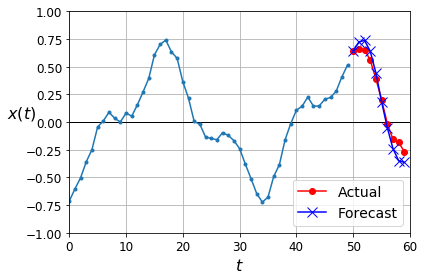

In [31]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0]) # (60, )
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

### option 2: spit out all 10 values all at once with a new model
Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [32]:
# naive approach
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [33]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [34]:
Y_pred.shape

(2000, 10)

In [35]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.025828114

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [36]:
Y_naive_pred = Y_valid[:, -1:] # at last time: (2000, 1)
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

It differs by a lot

In [37]:
# using simple RNN model
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 62us/sample - loss: 0.1335 - val_loss: 0.0605
Epoch 2/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0498 - val_loss: 0.0424
Epoch 3/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0385 - val_loss: 0.0354
Epoch 4/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0332 - val_loss: 0.0313
Epoch 5/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0298 - val_loss: 0.0282
Epoch 6/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0274 - val_loss: 0.0264
Epoch 7/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0257 - val_loss: 0.0249
Epoch 8/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0244 - val_loss: 0.0240
Epoch 9/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0235 - val_loss: 0.0229
Epoch 1

In [38]:
model.evaluate(X_valid, Y_valid, verbose=0)

0.018760286942124366

Saving figure forecast_ahead_plot


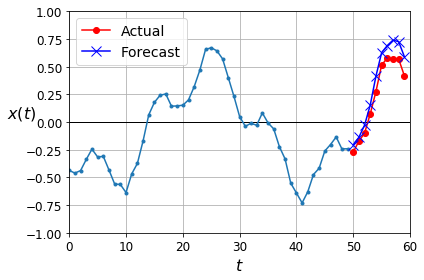

In [39]:
Y_pred = model.predict(X_valid)[..., np.newaxis]

plot_multiple_forecasts(X_valid, Y_valid[..., np.newaxis], Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's create an RNN that predicts all 10 next values at once:

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # no return_sequences at each iteration
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 805us/sample - loss: 0.0663 - val_loss: 0.0312
Epoch 2/20
7000/7000 [==============================] - 4s 622us/sample - loss: 0.0265 - val_loss: 0.0214
Epoch 3/20
7000/7000 [==============================] - 4s 634us/sample - loss: 0.0187 - val_loss: 0.0203
Epoch 4/20
7000/7000 [==============================] - 5s 668us/sample - loss: 0.0151 - val_loss: 0.0157
Epoch 5/20
7000/7000 [==============================] - 5s 693us/sample - loss: 0.0139 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 5s 717us/sample - loss: 0.0127 - val_loss: 0.0114
Epoch 7/20
7000/7000 [==============================] - 5s 738us/sample - loss: 0.0119 - val_loss: 0.0118
Epoch 8/20
7000/7000 [==============================] - 5s 743us/sample - loss: 0.0114 - val_loss: 0.0106
Epoch 9/20
7000/7000 [==============================] - 5s 779us/sample - loss: 0.0110 - val_loss: 0.011

In [41]:
model.evaluate(X_valid, Y_valid, verbose=0)

0.00797617257386446

In [42]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

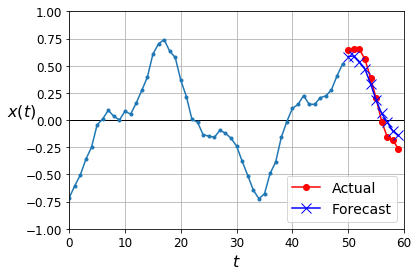

In [43]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Let's do a little bit better:

Instead of training the model to forecast the next 10 values only at the very last time step, we can train it to forecast the next 10 values at each and every time step. In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at the last time step. This means there will be many more error gradients flowing through the model, and they won’t have to flow only through time; they will also flow from the output of each time step. This will both stabilize and speed up training.

In [44]:
series.shape

(1, 60, 1)

In [45]:
Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors

for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [46]:
Y_train.shape

(7000, 50, 10)

In [47]:
X_train.shape

(7000, 50, 1)

In [48]:
Y_train[:, -1].shape

(7000, 10)

In [49]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True), # return_sequences at each iteration
    keras.layers.TimeDistributed(keras.layers.Dense(10)) # distributed throughout time
])

def last_time_step_mse(Y_true, Y_pred):
    """he output at the last time step is useful for predictions and for evaluation. 
    So although we will rely on the MSE over all the outputs for training, 
    we will use a custom metric for evaluation, 
    to only compute the MSE over the output at the last time step:"""
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

In [50]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 847us/sample - loss: 0.1365 - last_time_step_mse: 0.1530 - val_loss: 0.1130 - val_last_time_step_mse: 0.0711
Epoch 2/20
7000/7000 [==============================] - 5s 672us/sample - loss: 0.1245 - last_time_step_mse: 0.1365 - val_loss: 0.1069 - val_last_time_step_mse: 0.0957
Epoch 3/20
7000/7000 [==============================] - 5s 670us/sample - loss: 0.0095 - last_time_step_mse: 0.0175 - val_loss: 0.0016 - val_last_time_step_mse: 0.0026
Epoch 4/20
7000/7000 [==============================] - 5s 690us/sample - loss: 0.0019 - last_time_step_mse: 0.0039 - val_loss: 0.0020 - val_last_time_step_mse: 0.0031
Epoch 5/20
7000/7000 [==============================] - 5s 691us/sample - loss: 0.0017 - last_time_step_mse: 0.0035 - val_loss: 0.0023 - val_last_time_step_mse: 0.0078
Epoch 6/20
7000/7000 [==============================] - 5s 692us/sample - loss: 0.0017 - last_time_step_mse: 0.0

In [51]:
model.evaluate(X_valid, Y_valid, verbose=0)

[0.000592433974146843, 0.0014202514]

In [52]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)

In [53]:
Y_pred.shape

(1, 50, 10)

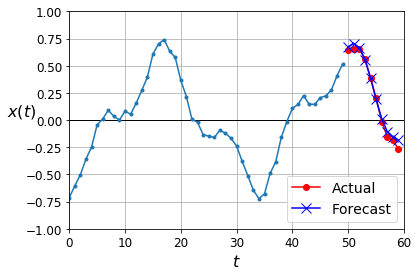

In [54]:
plot_multiple_forecasts(X_new, Y_new, Y_pred[:, -1].reshape(1, 10, 1))
plt.show()

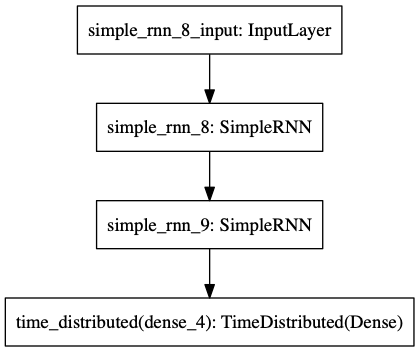

In [55]:
# plot model structure
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [56]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


# Deep RNN with Batch Norm
We need to define a custom memory cell. It is just like a regular layer, except its call() method takes two arguments: the inputs at the current time step and the hidden states from the previous time step. Note that the states argument is a list containing one or more tensors. In the case of a simple RNN cell it contains a single tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors. A cell must also have a state_size attribute and an output_size attribute. In a simple RNN, both are simply equal to the number of units.

In [57]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.1974 - last_time_step_mse: 0.2093 - val_loss: 0.1276 - val_last_time_step_mse: 0.1354
Epoch 2/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.1076 - last_time_step_mse: 0.1127 - val_loss: 0.0684 - val_last_time_step_mse: 0.0792
Epoch 3/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0240 - last_time_step_mse: 0.0276 - val_loss: 0.0098 - val_last_time_step_mse: 0.0083
Epoch 4/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0078 - last_time_step_mse: 0.0076 - val_loss: 0.0057 - val_last_time_step_mse: 0.0050
Epoch 5/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0051 - last_time_step_mse: 0.0052 - val_loss: 0.0036 - val_last_time_step_mse: 0.0034
Epoch 6/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0048 - last_time_step_mse: 0.0047 - 

In [59]:
model.evaluate(X_valid, Y_valid, verbose=0)

[0.0007978439121507108, 0.00060257904]

In [60]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [61]:
Y_pred.shape

(1, 10, 1)

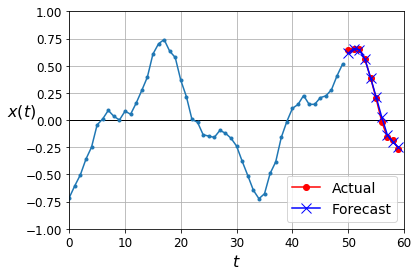

In [62]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Creating a Custom RNN Class

In [63]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.2495 - last_time_step_mse: 0.2686 - val_loss: 0.1489 - val_last_time_step_mse: 0.1728
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.1437 - last_time_step_mse: 0.1676 - val_loss: 0.1405 - val_last_time_step_mse: 0.1654
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.1390 - last_time_step_mse: 0.1623 - val_loss: 0.1376 - val_last_time_step_mse: 0.1587
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.1366 - last_time_step_mse: 0.1555 - val_loss: 0.1355 - val_last_time_step_mse: 0.1556
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.1219 - last_time_step_mse: 0.1568 - val_loss: 0.0460 - val_last_time_step_mse: 0.0805
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0251 - last_time_step_mse: 0.0229 - val_l

In [65]:
model.evaluate(X_valid, Y_valid, verbose=0)

[0.0011224450441077352, 0.0012535142]

# LSTMs

In [66]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [67]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0602 - last_time_step_mse: 0.0791 - val_loss: 0.0108 - val_last_time_step_mse: 0.0068
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0045 - last_time_step_mse: 0.0041 - val_loss: 0.0025 - val_last_time_step_mse: 0.0025
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0019 - last_time_step_mse: 0.0020 - val_loss: 0.0016 - val_last_time_step_mse: 0.0015
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0013 - last_time_step_mse: 0.0013 - val_loss: 0.0013 - val_last_time_step_mse: 0.0016
Epoch 5/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0010 - last_time_step_mse: 8.8626e-04 - val_loss: 9.4018e-04 - val_last_time_step_mse: 8.4267e-04
Epoch 6/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 8.6003e-04 - last_time_step_mse

In [68]:
model.evaluate(X_valid, Y_valid, verbose=0)

[0.000489498651586473, 0.00020308584]

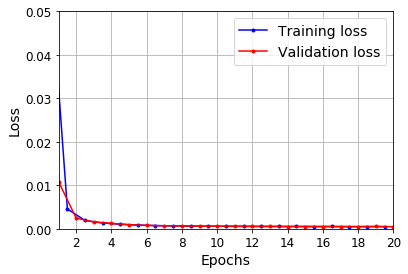

In [69]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [70]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

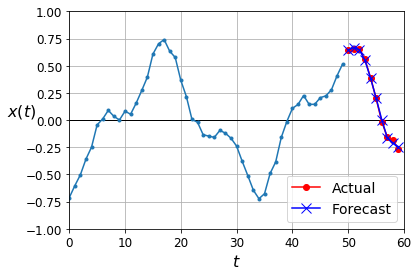

In [71]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [72]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0833 - last_time_step_mse: 0.0977 - val_loss: 0.0213 - val_last_time_step_mse: 0.0157
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0171 - last_time_step_mse: 0.0086 - val_loss: 0.0080 - val_last_time_step_mse: 0.0034
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0034 - last_time_step_mse: 0.0039 - val_loss: 0.0017 - val_last_time_step_mse: 0.0028
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0014 - last_time_step_mse: 0.0024 - val_loss: 0.0011 - val_last_time_step_mse: 0.0020
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0010 - last_time_step_mse: 0.0018 - val_loss: 8.8875e-04 - val_last_time_step_mse: 0.0014
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 8.0691e-04 - last_time_step_mse: 0.0013

In [73]:
model.evaluate(X_valid, Y_valid, verbose=0)

[0.0005156344436109066, 0.00019421232]

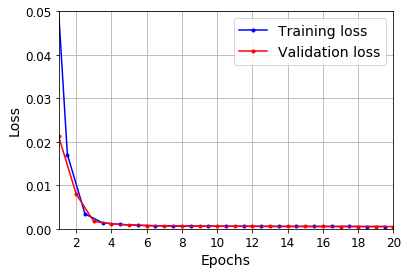

In [74]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [75]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

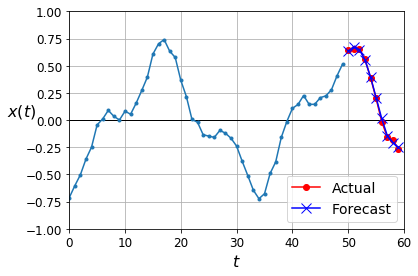

In [76]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [77]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0723 - last_time_step_mse: 0.0899 - val_loss: 0.0168 - val_last_time_step_mse: 0.0114
Epoch 2/20
7000/7000 [==============================] - 4s 594us/sample - loss: 0.0056 - last_time_step_mse: 0.0029 - val_loss: 0.0011 - val_last_time_step_mse: 4.6810e-04
Epoch 3/20
7000/7000 [==============================] - 4s 633us/sample - loss: 7.4469e-04 - last_time_step_mse: 3.5572e-04 - val_loss: 5.4348e-04 - val_last_time_step_mse: 1.8444e-04
Epoch 4/20
7000/7000 [==============================] - 4s 638us/sample - loss: 4.6413e-04 - last_time_step_mse: 1.6748e-04 - val_loss: 4.0104e-04 - val_last_time_step_mse: 1.1433e-04
Epoch 5/20
7000/7000 [==============================] - 4s 630us/sample - loss: 3.6793e-04 - last_time_step_mse: 1.5256e-04 - val_loss: 3.3167e-04 - val_last_time_step_mse: 1.5143e-04
Epoch 6/20
7000/7000 [==============================] - 4s 617

In [78]:
model.evaluate(X_valid, Y_valid[:, 3::2], verbose=0)

[9.192286775214598e-05, 1.6869211e-05]

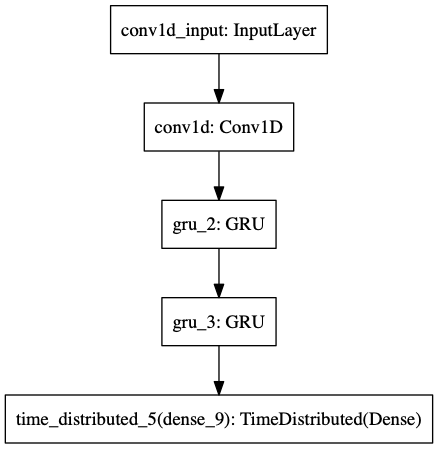

In [79]:
# plot model structure
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [80]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          100       
_________________________________________________________________
gru_2 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
gru_3 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 10)          210       
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________


## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure15_11.png?raw=true" alt="Figure 15-11" width=700>

<img src="https://i.stack.imgur.com/m6gDp.gif" width=700>

In [81]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2: # (1, 2, 4, 8, 1, 2, 4, 8)
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 554us/sample - loss: 0.0813 - last_time_step_mse: 0.2116 - val_loss: 0.0541 - val_last_time_step_mse: 0.2257
Epoch 2/20
7000/7000 [==============================] - 2s 279us/sample - loss: 0.0522 - last_time_step_mse: 0.2235 - val_loss: 0.0512 - val_last_time_step_mse: 0.2258
Epoch 3/20
7000/7000 [==============================] - 2s 268us/sample - loss: 0.0509 - last_time_step_mse: 0.2214 - val_loss: 0.0504 - val_last_time_step_mse: 0.2208
Epoch 4/20
7000/7000 [==============================] - 2s 273us/sample - loss: 0.0504 - last_time_step_mse: 0.2207 - val_loss: 0.0501 - val_last_time_step_mse: 0.2210
Epoch 5/20
7000/7000 [==============================] - 2s 260us/sample - loss: 0.0501 - last_time_step_mse: 0.2204 - val_loss: 0.0500 - val_last_time_step_mse: 0.2205
Epoch 6/20
7000/7000 [==============================] - 2s 254us/sample - loss: 0.0499 - last_time_step_mse: 0.2

In [82]:
model.evaluate(X_valid, Y_valid, verbose=0)

[0.04893650451302528, 0.22104679]

Here is the `original WaveNet defined in the paper`: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [83]:
from tensorflow import keras

class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [84]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [85]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [86]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 4s 612us/sample - loss: 0.1380 - last_time_step_mse: 0.1537 - val_loss: 0.1364 - val_last_time_step_mse: 0.1477
Epoch 2/2
7000/7000 [==============================] - 2s 335us/sample - loss: 0.1362 - last_time_step_mse: 0.1475 - val_loss: 0.1360 - val_last_time_step_mse: 0.1471


In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.